In [1]:
# alice viggiani
# 612 advanced gis
# November, 2025

## Languages spoken at home in the US and gentrification index

**Data sources**<br>
<small>S1602 Limited English spoken at home, 2023, US Census<br>
Gentrification intensity map, 1990-2020, John Lauermann<br>
Spatial datasets, CBSA boundaries, tracts boundaries, Geographic relationship tracts, Census<br></small>

**Geography**<br>
<small>Four most populated metropolitan areas from the US, studied by tracts:<br>
Chicago-Naperville-Elgin, IL-IN Metro Area<br>
Dallas-Fort Worth-Arlington, TX Metro Area<br>
Los Angeles-Long Beach-Anaheim, CA Metro Area<br>
New York-Newark-Jersey City, NY-NJ Metro Area<br></small>

**Intro**<br>
<small>The study seeks to visualize and interpret how the process of gentrification in US tracts relates to the languages spoken in households across the four most populous metropolitan areas. It investigates whether Census tracts with high gentrification scores coincide with a high concentration of residents who speak particular languages at home, such as Spanish, Western European, and Slavic languages.<br>
The preliminary spatial representation visually pairs the gentrification score and the concentration of the language spoken population, by each of the four metropolitan areas, and by each of the language agglomerations.<br>
The analysis of the datasets was conducted using Bivariate Moran’s I, Local Moran's I, and clusters, as well as the shares of how much of each language spoken population is exposed to gentrified or super-gentrified regions.</small>



**Summary**

**1. Data**<br>
<small>1.1 Languages dataset<br>
1.2 Spatial data base<br>
1.3 Gentrification intensity data<br>
<br></small>
**2. Visualizations**
<small>2.1 Setup<br>
2.2 Computations<br>
<br></small>
**3. Spatial statistics**<br>
<small>3.1 Bivariate Moran's I<br>
3.2 Local Moran's I<br>
3.3 Shares of gentrification exposure index</small>


In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from IPython.display import display, HTML

import esda
from esda.moran import Moran_BV, Moran_Local_BV
import libpysal as lps
import mapclassify
import matplotlib.pyplot as plt

import seaborn
import warnings

from geopandas import GeoDataFrame
from matplotlib import colors
from shapely.geometry import Point

### **1. Data**


### 1.1 Languages dataset

In [ ]:
# reading first dataset
# languages spoken at home
# by tract
# census 

# language_path = "/Users/aliceviggiani/Dropbox/1 estudos/5 data viz/0 master/pratt/3-2025-fall/612-advanced_gis/lab2-spatial_statistics/0-data/2023-B16002-tract_selection-2/ACSDT5Y2023.B16002-Data.csv"
language_path  = "https://github.com/aliceaviggiani/612-languages-gentrification/blob/main/data/2023-B16002-tract_selection-2/ACSDT5Y2023.B16002-Data.csv?raw=true"
df_languages = pd.read_csv(language_path, header=1)

df_languages

,Geography,Geographic Area Name,Estimate!!Total:,Margin of Error!!Total:,Estimate!!Total:!!English only,Margin of Error!!Total:!!English only,Estimate!!Total:!!Spanish:,Margin of Error!!Total:!!Spanish:,Estimate!!Total:!!Spanish:!!Limited English speaking household,Margin of Error!!Total:!!Spanish:!!Limited English speaking household,...,Margin of Error!!Total:!!Arabic:!!Limited English speaking household,Estimate!!Total:!!Arabic:!!Not a limited English speaking household,Margin of Error!!Total:!!Arabic:!!Not a limited English speaking household,Estimate!!Total:!!Other and unspecified languages:,Margin of Error!!Total:!!Other and unspecified languages:,Estimate!!Total:!!Other and unspecified languages:!!Limited English speaking household,Margin of Error!!Total:!!Other and unspecified languages:!!Limited English speaking household,Estimate!!Total:!!Other and unspecified languages:!!Not a limited English speaking household,Margin of Error!!Total:!!Other and unspecified languages:!!Not a limited English speaking household,Unnamed: 78
0,1400000US06001400100,Census Tract 4001; Alameda County; California,1316,142,917,137,117,82,0,14,...,14,9,15,8,13,0,14,8,13,NaN
1,1400000US06001400200,Census Tract 4002; Alameda County; California,861,86,671,98,75,48,0,14,...,14,0,14,0,14,0,14,0,14,NaN
2,1400000US06001400300,Census Tract 4003; Alameda County; California,2713,273,2016,238,152,138,0,19,...,19,0,19,143,75,96,82,47,47,NaN
3,1400000US06001400400,Census Tract 4004; Alameda County; California,1803,173,1383,158,203,123,8,12,...,14,0,14,0,14,0,14,0,14,NaN
4,1400000US06001400500,Census Tract 4005; Alameda County; California,1655,283,1307,279,144,66,0,14,...,14,0,14,24,40,24,40,0,14,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37447,1400000US55141011300,Census Tract 113; Wood County; Wisconsin,2084,240,1958,255,13,22,0,10,...,10,0,10,0,10,0,10,0,10,NaN
37448,1400000US55141011400,Census Tract 114; Wood County; Wisconsin,2304,280,2257,284,0,10,0,10,...,10,0,10,0,10,0,10,0,10,NaN
37449,1400000US55141011500,Census Tract 115; Wood County; Wisconsin,2547,219,2440,230,0,14,0,14,...,14,0,14,0,14,0,14,0,14,NaN
37450,1400000US55141011600,Census Tract 116; Wood County; Wisconsin,2149,193,2149,193,0,10,0,10,...,10,0,10,0,10,0,10,0,10,NaN


In [3]:
df_languages = df_languages.loc[:, ~df_languages.columns.str.contains("Margin of Error")]
df_languages = df_languages.loc[:, ~df_languages.columns.str.contains("Limited English speaking household")]
df_languages = df_languages.loc[:, ~df_languages.columns.str.contains("Not a limited English speaking household")]
df_languages.pop('Unnamed: 78')

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
37447   NaN
37448   NaN
37449   NaN
37450   NaN
37451   NaN
Name: Unnamed: 78, Length: 37452, dtype: float64

In [7]:
# cleaning dataset
# census B16002

df_languages.columns = (df_languages.columns
    .str.replace("Estimate!!Total:!!", "", regex=False)
    .str.replace(":", "", regex=False)
    # .str.replace('""', '', regex=False)
    .str.replace(" ", "_", regex=False)
    .str.lower()
)
  
df_languages.columns = (df_languages.columns
    .str.replace("estimate!!", "", regex=False)
    .str.replace(",_haitian,_or_cajun", "", regex=False)
    .str.replace('german_or_other_', '', regex=False)
    .str.replace("russian,_polish,_or_other_", "", regex=False)
    .str.replace("other_indo-european_languages", "indo_european", regex=False)
    .str.replace("_(incl._mandarin,_cantonese)", "", regex=False)
    .str.replace("_(incl._filipino)", "", regex=False)
    .str.replace("other_asian_and_pacific_island_languages", "asian_others", regex=False)
    .str.replace("other_and_unspecified_languages", "unspecified", regex=False)
    .str.replace("other_and_unspecified_languages", "unspecified", regex=False)
)

df_languages

,geography,geographic_area_name,total,english_only,spanish,french,west_germanic_languages,slavic_languages,indo_european,korean,chinese,vietnamese,tagalog,asian_others,arabic,unspecified
0,1400000US06001400100,Census Tract 4001; Alameda County; California,1316,917,117,29,25,10,64,13,91,7,0,17,18,8
1,1400000US06001400200,Census Tract 4002; Alameda County; California,861,671,75,20,5,4,36,8,17,0,11,14,0,0
2,1400000US06001400300,Census Tract 4003; Alameda County; California,2713,2016,152,27,13,16,175,21,38,0,33,79,0,143
3,1400000US06001400400,Census Tract 4004; Alameda County; California,1803,1383,203,35,15,4,42,8,38,35,19,21,0,0
4,1400000US06001400500,Census Tract 4005; Alameda County; California,1655,1307,144,35,0,22,45,0,22,8,41,7,0,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37447,1400000US55141011300,Census Tract 113; Wood County; Wisconsin,2084,1958,13,0,40,0,15,0,0,0,27,31,0,0
37448,1400000US55141011400,Census Tract 114; Wood County; Wisconsin,2304,2257,0,47,0,0,0,0,0,0,0,0,0,0
37449,1400000US55141011500,Census Tract 115; Wood County; Wisconsin,2547,2440,0,0,62,28,0,0,17,0,0,0,0,0
37450,1400000US55141011600,Census Tract 116; Wood County; Wisconsin,2149,2149,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
# creating auxiliary columns

df_languages[['tract', 'county', 'state']] = (
    df_languages['geographic_area_name']
    .str.split(';', expand=True)
)

df_languages['tract'] = df_languages['tract'].str.strip()
df_languages['county'] = df_languages['county'].str.strip()
df_languages['state'] = df_languages['state'].str.strip()

df_languages['tract'] = (
    df_languages['tract']
        .str.replace("Census Tract ", "")
)

state_abbr = {
    "California": "CA",
    "Texas": "TX",
    "New York": "NY",
    "New Jersey": "NJ",
    "Pennsylvania": "PA",
    "Connecticut": "CT",
    "Illinois": "IL",
    "Wisconsin": "WI",
    "Indiana": "IN",
}

df_languages["state_abb"] = df_languages["state"].map(state_abbr)

df_languages.columns

Index(['geography', 'geographic_area_name', 'total', 'english_only', 'spanish',
       'french', 'west_germanic_languages', 'slavic_languages',
       'indo_european', 'korean', 'chinese', 'vietnamese', 'tagalog',
       'asian_others', 'arabic', 'unspecified', 'tract', 'county', 'state',
       'state_abb'],
      dtype='object')

In [10]:
# grouping languages

# west european languages
# includes french, haitian, cajun, german_or_other_west_germanic_languages, yiddish, dutch, afrikaans
df_languages["west_european"] = (
    df_languages["french"] + 
    df_languages["west_germanic_languages"]
)

# east and southeast asian languages
# includes korean, chinese languages, vietnamese, tagalog, other asian and pacific island languages
df_languages["east_se_asian"] = (
    df_languages["korean"] + 
    df_languages["chinese"] +
    df_languages["vietnamese"] +
    df_languages["tagalog"] +
    df_languages["asian_others"]
)

# spanish

# slavic_languages
# includes russian and polish

# indo-european_others
# includes italian, portuguese, scandinavian, baltic languages like lithuanian and latvian, albanian, romanian
# punjabi, bengali, nepali

# arabic

# others
# includes unspecified

df_languages

,geography,geographic_area_name,total,english_only,spanish,french,west_germanic_languages,slavic_languages,indo_european,korean,...,tagalog,asian_others,arabic,unspecified,tract,county,state,state_abb,west_european,east_se_asian
0,1400000US06001400100,Census Tract 4001; Alameda County; California,1316,917,117,29,25,10,64,13,...,0,17,18,8,4001,Alameda County,California,CA,54,128
1,1400000US06001400200,Census Tract 4002; Alameda County; California,861,671,75,20,5,4,36,8,...,11,14,0,0,4002,Alameda County,California,CA,25,50
2,1400000US06001400300,Census Tract 4003; Alameda County; California,2713,2016,152,27,13,16,175,21,...,33,79,0,143,4003,Alameda County,California,CA,40,171
3,1400000US06001400400,Census Tract 4004; Alameda County; California,1803,1383,203,35,15,4,42,8,...,19,21,0,0,4004,Alameda County,California,CA,50,121
4,1400000US06001400500,Census Tract 4005; Alameda County; California,1655,1307,144,35,0,22,45,0,...,41,7,0,24,4005,Alameda County,California,CA,35,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37447,1400000US55141011300,Census Tract 113; Wood County; Wisconsin,2084,1958,13,0,40,0,15,0,...,27,31,0,0,113,Wood County,Wisconsin,WI,40,58
37448,1400000US55141011400,Census Tract 114; Wood County; Wisconsin,2304,2257,0,47,0,0,0,0,...,0,0,0,0,114,Wood County,Wisconsin,WI,47,0
37449,1400000US55141011500,Census Tract 115; Wood County; Wisconsin,2547,2440,0,0,62,28,0,0,...,0,0,0,0,115,Wood County,Wisconsin,WI,62,17
37450,1400000US55141011600,Census Tract 116; Wood County; Wisconsin,2149,2149,0,0,0,0,0,0,...,0,0,0,0,116,Wood County,Wisconsin,WI,0,0


In [11]:
# formating geoid

df_languages["geography_short"] = df_languages["geography"].str.replace("1400000US", "")

df_languages['geoid'] = (
    df_languages['geography_short']
    .astype(str)
)

df_languages['geoid']

0        06001400100
1        06001400200
2        06001400300
3        06001400400
4        06001400500
            ...     
37447    55141011300
37448    55141011400
37449    55141011500
37450    55141011600
37451    55141011700
Name: geoid, Length: 37452, dtype: object

In [12]:
# checking geoid

df_languages['geoid'].str.len().value_counts()

geoid
11    37452
Name: count, dtype: int64

In [13]:
# reorgaizing columns

id = df_languages.pop('geoid')
df_languages.insert(0, 'geoid', id)

state = df_languages.pop('state_abb')
df_languages.insert(1, 'state_abb', state)

county = df_languages.pop('county')
df_languages.insert(2, 'county', county)

tr = df_languages.pop('tract')
df_languages.insert(3, 'tract', tr)

eu = df_languages.pop('west_european')
df_languages.insert(19, 'west_european', eu)

asian = df_languages.pop('east_se_asian')
df_languages.insert(20, 'east_se_asian', asian)

geo = df_languages.pop('geography')
df_languages.insert(len(df_languages.columns), 'geography', geo)

df_languages.pop('geography_short')

df_languages

,geoid,state_abb,county,tract,geographic_area_name,total,english_only,spanish,french,west_germanic_languages,...,chinese,vietnamese,tagalog,asian_others,arabic,west_european,east_se_asian,unspecified,state,geography
0,06001400100,CA,Alameda County,4001,Census Tract 4001; Alameda County; California,1316,917,117,29,25,...,91,7,0,17,18,54,128,8,California,1400000US06001400100
1,06001400200,CA,Alameda County,4002,Census Tract 4002; Alameda County; California,861,671,75,20,5,...,17,0,11,14,0,25,50,0,California,1400000US06001400200
2,06001400300,CA,Alameda County,4003,Census Tract 4003; Alameda County; California,2713,2016,152,27,13,...,38,0,33,79,0,40,171,143,California,1400000US06001400300
3,06001400400,CA,Alameda County,4004,Census Tract 4004; Alameda County; California,1803,1383,203,35,15,...,38,35,19,21,0,50,121,0,California,1400000US06001400400
4,06001400500,CA,Alameda County,4005,Census Tract 4005; Alameda County; California,1655,1307,144,35,0,...,22,8,41,7,0,35,78,24,California,1400000US06001400500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37447,55141011300,WI,Wood County,113,Census Tract 113; Wood County; Wisconsin,2084,1958,13,0,40,...,0,0,27,31,0,40,58,0,Wisconsin,1400000US55141011300
37448,55141011400,WI,Wood County,114,Census Tract 114; Wood County; Wisconsin,2304,2257,0,47,0,...,0,0,0,0,0,47,0,0,Wisconsin,1400000US55141011400
37449,55141011500,WI,Wood County,115,Census Tract 115; Wood County; Wisconsin,2547,2440,0,0,62,...,17,0,0,0,0,62,17,0,Wisconsin,1400000US55141011500
37450,55141011600,WI,Wood County,116,Census Tract 116; Wood County; Wisconsin,2149,2149,0,0,0,...,0,0,0,0,0,0,0,0,Wisconsin,1400000US55141011600


In [ ]:
# exporting df_languages

df_languages.to_csv("df_languages-5.csv", index=False)

#### 1.2 Spatial data base

In [ ]:
# reading gdf with geopandas
# tracts boundaries

# tracts_path = "/Users/aliceviggiani/Dropbox/1 estudos/5 data viz/0 master/pratt/3-2025-fall/612-advanced_gis/lab2-spatial_statistics/3-produced/tracts_3.gpkg"
tracts_path = "https://github.com/aliceaviggiani/612-languages-gentrification/tree/main/data/tracts_3.gpkg?raw=true"
gdf_tracts = gpd.read_file(tracts_path, layer="tracts_3")

gdf_tracts.columns

Index(['STATE_ABBR', 'STATE_FIPS', 'COUNTY_FIP', 'STCOFIPS', 'TRACT_FIPS',
       'FIPS', 'POPULATION', 'POP_SQMI', 'SQMI', 'POPULATI_1', 'POP20_SQMI',
       'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object')

In [23]:
# creating a compatible geoid key

gdf_tracts['geoid'] = (
    gdf_tracts['FIPS']
    .astype(str)
)

idt = gdf_tracts.pop('geoid')
gdf_tracts.insert(0, 'geoid', idt)

gdf_tracts['geoid'].str.len().value_counts()

geoid
11    12322
Name: count, dtype: int64

In [ ]:
# reading gdf with geopandas
# cbsas boundaries

# cbsa_path = "/Users/aliceviggiani/Dropbox/1 estudos/5 data viz/0 master/pratt/3-2025-fall/612-advanced_gis/lab2-spatial_statistics/0-data/tl_2019_us_cbsa/tl_2019_us_cbsa.shp"
cbsa_path = "https://raw.githubusercontent.com/aliceaviggiani/612-languages-gentrification/refs/heads/main/data/tl_2019_us_cbsa/tl_2019_us_cbsa.shp.ea.iso.xml"
gdf_cbsa = gpd.read_file(cbsa_path)

gdf_cbsa.columns

Index(['CSAFP', 'CBSAFP', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD', 'MEMI', 'MTFCC',
       'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

In [ ]:
# formating variables 

# cbsa
gdf_cbsa["cbsa_code"] = (
    gdf_cbsa["CBSAFP"]
    .astype(float)
    .astype(int)
    .astype(str)
)

gdf_cbsa['cbsa_code'].str.len().value_counts()

cbsa_code
5    938
Name: count, dtype: int64

In [51]:
# joining spatial data
# tracts + cbsas

# setting projection
# us albers, code 5070
gdf_tracts = gdf_tracts.to_crs(5070)
gdf_cbsa = gdf_cbsa.to_crs(5070)

# spatial join, only with necessary variables
gdf_base_temp = gpd.sjoin(
    gdf_tracts[['geoid', 'geometry']],
    gdf_cbsa[['cbsa_code', 'geometry']],
    how='left',
    predicate='intersects'
)

# merging back
gdf_base = gdf_tracts.merge(
    gdf_base_temp,
    on='geoid',
    how='left',
)

cb = gdf_base.pop('cbsa_code')
gdf_base.insert(1, 'cbsa_code', cb)

gdf_base

,geoid,cbsa_code,STATE_ABBR,STATE_FIPS,COUNTY_FIP,STCOFIPS,TRACT_FIPS,FIPS,POPULATION,POP_SQMI,SQMI,POPULATI_1,POP20_SQMI,Shape__Are,Shape__Len,geometry_x,geometry_centroid,geometry_y,index_right
0,06029005513,31080,CA,06,029,06029,005513,06029005513,2560,285.7,8.96,2549,284.5,0.002288,0.307434,"POLYGON ((-1994876.941 1547321.638, -1994862.9...",POINT (-1994714.262 1542841.648),"POLYGON ((-1994876.941 1547321.638, -1994862.9...",511.0
1,06029005513,12540,CA,06,029,06029,005513,06029005513,2560,285.7,8.96,2549,284.5,0.002288,0.307434,"POLYGON ((-1994876.941 1547321.638, -1994862.9...",POINT (-1994714.262 1542841.648),"POLYGON ((-1994876.941 1547321.638, -1994862.9...",12.0
2,06029003308,12540,CA,06,029,06029,003308,06029003308,2170,73.6,29.49,2099,71.2,0.007528,0.817624,"POLYGON ((-2054182.513 1558129.603, -2054146.5...",POINT (-2063462.598 1559464.099),"POLYGON ((-2054182.513 1558129.603, -2054146.5...",12.0
3,06029006011,31080,CA,06,029,06029,006011,06029006011,3606,7.8,460.22,3508,7.6,0.117657,1.757721,"POLYGON ((-2037015.621 1592555.214, -2036904.5...",POINT (-2037982.686 1568622.852),"POLYGON ((-2037015.621 1592555.214, -2036904.5...",511.0
4,06029006011,12540,CA,06,029,06029,006011,06029006011,3606,7.8,460.22,3508,7.6,0.117657,1.757721,"POLYGON ((-2037015.621 1592555.214, -2036904.5...",POINT (-2037982.686 1568622.852),"POLYGON ((-2037015.621 1592555.214, -2036904.5...",12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12683,55127000600,27500,WI,55,127,55127,000600,55127000600,5411,76.9,70.38,5496,78.1,0.019988,0.651988,"POLYGON ((597533.494 2208815.434, 597539.854 2...",POINT (593435.602 2198386.811),"POLYGON ((597533.494 2208815.434, 597539.854 2...",428.0
12684,55127001702,48580,WI,55,127,55127,001702,55127001702,5433,91.0,59.70,5320,89.1,0.016941,1.037622,"POLYGON ((604693.627 2199691.113, 604701.257 2...",POINT (611468.292 2193756.388),"POLYGON ((604693.627 2199691.113, 604701.257 2...",923.0
12685,55127001000,48580,WI,55,127,55127,001000,55127001000,5055,92.3,54.77,5036,91.9,0.015568,0.662217,"POLYGON ((610442.049 2209925.527, 611124.875 2...",POINT (618474.349 2206396.13),"POLYGON ((610442.049 2209925.527, 611124.875 2...",923.0
12686,55127001701,16980,WI,55,127,55127,001701,55127001701,6035,320.3,18.84,5918,314.1,0.005347,0.321013,"POLYGON ((625130.223 2201220.257, 625214.048 2...",POINT (623740.856 2197953.517),"POLYGON ((625130.223 2201220.257, 625214.048 2...",278.0


In [90]:
# joining spatial data and tabular data

gdf_languages_tracts = gdf_base.merge(
    df_languages,
    on="geoid",
    how="left"
)

gdf_languages_tracts

,geoid,cbsa_code,STATE_ABBR,STATE_FIPS,COUNTY_FIP,STCOFIPS,TRACT_FIPS,FIPS,POPULATION,POP_SQMI,...,chinese,vietnamese,tagalog,asian_others,arabic,west_european,east_se_asian,unspecified,state,geography
0,06029005513,31080,CA,06,029,06029,005513,06029005513,2560,285.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,California,1400000US06029005513
1,06029005513,12540,CA,06,029,06029,005513,06029005513,2560,285.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,California,1400000US06029005513
2,06029003308,12540,CA,06,029,06029,003308,06029003308,2170,73.6,...,0.0,0.0,15.0,0.0,0.0,0.0,67.0,0.0,California,1400000US06029003308
3,06029006011,31080,CA,06,029,06029,006011,06029006011,3606,7.8,...,0.0,0.0,0.0,0.0,0.0,41.0,0.0,0.0,California,1400000US06029006011
4,06029006011,12540,CA,06,029,06029,006011,06029006011,3606,7.8,...,0.0,0.0,0.0,0.0,0.0,41.0,0.0,0.0,California,1400000US06029006011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12683,55127000600,27500,WI,55,127,55127,000600,55127000600,5411,76.9,...,0.0,0.0,8.0,0.0,0.0,19.0,8.0,0.0,Wisconsin,1400000US55127000600
12684,55127001702,48580,WI,55,127,55127,001702,55127001702,5433,91.0,...,0.0,0.0,0.0,2.0,0.0,49.0,2.0,0.0,Wisconsin,1400000US55127001702
12685,55127001000,48580,WI,55,127,55127,001000,55127001000,5055,92.3,...,14.0,0.0,0.0,0.0,0.0,44.0,14.0,0.0,Wisconsin,1400000US55127001000
12686,55127001701,16980,WI,55,127,55127,001701,55127001701,6035,320.3,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,Wisconsin,1400000US55127001701


In [84]:
# checking cbsa_code
gdf_languages_tracts['cbsa_code'].str.len().value_counts()

cbsa_code
5.0    12684
Name: count, dtype: int64

In [69]:
# checking nans
gdf_languages_tracts[gdf_languages_tracts.isna().any(axis=1)]

,geoid,cbsa_code,STATE_ABBR,STATE_FIPS,COUNTY_FIP,STCOFIPS,TRACT_FIPS,FIPS,POPULATION,POP_SQMI,...,chinese,vietnamese,tagalog,asian_others,arabic,west_european,east_se_asian,unspecified,state,geography
3252,09001210502,35620,CT,09,001,09001,210502,09001210502,6526,1129.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3253,09001210502,14860,CT,09,001,09001,210502,09001210502,6526,1129.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3254,09001245600,35620,CT,09,001,09001,245600,09001245600,5886,573.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3255,09001245600,14860,CT,09,001,09001,245600,09001245600,5886,573.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3256,09001245400,14860,CT,09,001,09001,245400,09001245400,3401,688.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3257,09001010400,35620,CT,09,001,09001,010400,09001010400,5805,5476.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3258,09001010400,14860,CT,09,001,09001,010400,09001010400,5805,5476.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3259,09001220100,35620,CT,09,001,09001,220100,09001220100,4905,1122.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3260,09001220100,14860,CT,09,001,09001,220100,09001220100,4905,1122.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3261,09001035200,35620,CT,09,001,09001,035200,09001035200,3306,478.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
gdf_languages_tracts[gdf_languages_tracts.isna().any(axis=1)]
gdf_languages_tracts.isna().any(axis=1).sum()


55

In [91]:
gdf_languages_tracts.columns

Index(['geoid', 'cbsa_code', 'STATE_ABBR', 'STATE_FIPS', 'COUNTY_FIP',
       'STCOFIPS', 'TRACT_FIPS', 'FIPS', 'POPULATION', 'POP_SQMI', 'SQMI',
       'POPULATI_1', 'POP20_SQMI', 'Shape__Are', 'Shape__Len', 'geometry_x',
       'geometry_centroid', 'geometry_y', 'index_right', 'state_abb', 'county',
       'tract', 'geographic_area_name', 'total', 'english_only', 'spanish',
       'french', 'west_germanic_languages', 'slavic_languages',
       'indo_european', 'korean', 'chinese', 'vietnamese', 'tagalog',
       'asian_others', 'arabic', 'west_european', 'east_se_asian',
       'unspecified', 'state', 'geography'],
      dtype='object')

In [92]:
# cleaning geometry columns

geos = [col for col in gdf_languages_tracts.columns 
             if gdf_languages_tracts[col].dtype == 'geometry'
             ]

gdf_languages_tracts = gdf_languages_tracts.drop(
    columns=[col for col in geos if col != 'geometry_x']
)

gdf_languages_tracts = gdf_languages_tracts.rename(columns={"geometry_x": "geometry", "STATE_ABBR": "state_abbr" })

gdf_languages_tracts

,geoid,cbsa_code,state_abbr,STATE_FIPS,COUNTY_FIP,STCOFIPS,TRACT_FIPS,FIPS,POPULATION,POP_SQMI,...,chinese,vietnamese,tagalog,asian_others,arabic,west_european,east_se_asian,unspecified,state,geography
0,06029005513,31080,CA,06,029,06029,005513,06029005513,2560,285.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,California,1400000US06029005513
1,06029005513,12540,CA,06,029,06029,005513,06029005513,2560,285.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,California,1400000US06029005513
2,06029003308,12540,CA,06,029,06029,003308,06029003308,2170,73.6,...,0.0,0.0,15.0,0.0,0.0,0.0,67.0,0.0,California,1400000US06029003308
3,06029006011,31080,CA,06,029,06029,006011,06029006011,3606,7.8,...,0.0,0.0,0.0,0.0,0.0,41.0,0.0,0.0,California,1400000US06029006011
4,06029006011,12540,CA,06,029,06029,006011,06029006011,3606,7.8,...,0.0,0.0,0.0,0.0,0.0,41.0,0.0,0.0,California,1400000US06029006011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12683,55127000600,27500,WI,55,127,55127,000600,55127000600,5411,76.9,...,0.0,0.0,8.0,0.0,0.0,19.0,8.0,0.0,Wisconsin,1400000US55127000600
12684,55127001702,48580,WI,55,127,55127,001702,55127001702,5433,91.0,...,0.0,0.0,0.0,2.0,0.0,49.0,2.0,0.0,Wisconsin,1400000US55127001702
12685,55127001000,48580,WI,55,127,55127,001000,55127001000,5055,92.3,...,14.0,0.0,0.0,0.0,0.0,44.0,14.0,0.0,Wisconsin,1400000US55127001000
12686,55127001701,16980,WI,55,127,55127,001701,55127001701,6035,320.3,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,Wisconsin,1400000US55127001701


In [93]:
# exporting df_languages

gdf_languages_tracts.to_file("df_languages_tracts-14.gpkg", 
                             layer="tracts_languages_8",
                             driver="GPKG"
)

#### 1.3 Gentrification intensity data

In [ ]:
# loading gentrification data

# gent_path = "/Users/aliceviggiani/Dropbox/1 estudos/5 data viz/0 master/pratt/3-2025-fall/612-advanced_gis/lab2-spatial_statistics/0-data/03_spatial/metrotracts_gentscores_2020tr.csv"
gent_path = "https://drive.google.com/file/d/1DkLJeanB1JGFXWhTFrp1Z4lGCFi5rSyf/view?usp=sharing"
df_gent = pd.read_csv(gent_path)

df_gent.columns

Index(['tr2020gj', 'CBSAFP', 'Bach_pct_1990', 'Bach_pct_2000', 'Bach_pct_2010',
       'Bach_pct_2020', 'Bach_pct_chg_1990to2000', 'Bach_pct_chg_1990to2020',
       'Bach_pct_chg_2000to2010', 'Bach_pct_chg_2010to2020', 'classtype',
       'ConRent_mean_1990', 'ConRent_mean_2000', 'ConRent_mean_2010',
       'ConRent_mean_2020', 'ConRent_mean_chg_1990to2000',
       'ConRent_mean_chg_1990to2020', 'ConRent_mean_chg_2000to2010',
       'ConRent_mean_chg_2010to2020', 'FAC_1990', 'FAC_1990to2000',
       'FAC_1990to2020', 'FAC_2000', 'FAC_2000to2010', 'FAC_2010',
       'FAC_2010to2020', 'FAC_2020', 'Gentrified', 'Gentrified_00to10',
       'Gentrified_10to20', 'Gentrified_90to00', 'Gentrifying_00to10',
       'Gentrifying_10to20', 'Gentrifying_90to00', 'HHIncome_mean_1990',
       'HHIncome_mean_2000', 'HHIncome_mean_2010', 'HHIncome_mean_2020',
       'HHIncome_mean_chg_1990to2000', 'HHIncome_mean_chg_1990to2020',
       'HHIncome_mean_chg_2000to2010', 'HHIncome_mean_chg_2010to2020',
    

In [106]:
# converting gisjoin to geoid to create a common key with the other dfs 

df_gent['tr2020gj_short'] = df_gent['tr2020gj'].str.replace('G', '')

# xx0 xxx0 xxxxxx
# 012 3456 789012

df_gent['state'] = df_gent['tr2020gj_short'].str.slice(0, 3)
df_gent['county'] = df_gent['tr2020gj_short'].str.slice(3, 7)
df_gent['tract'] = df_gent['tr2020gj_short'].str.slice(7, 13)

df_gent['state'] = df_gent['state'].str.replace('0$', '', regex=True)
df_gent['county'] = df_gent['county'].str.replace('0$', '', regex=True)
df_gent['tract'] = df_gent['tract'].astype(str)

df_gent['geoid'] = (
    df_gent['state'] + 
    df_gent['county'] + 
    df_gent['tract']
)

idg = df_gent.pop('geoid')
df_gent.insert(0, 'geoid', idg)

df_gent

,geoid,tr2020gj,CBSAFP,Bach_pct_1990,Bach_pct_2000,Bach_pct_2010,Bach_pct_2020,Bach_pct_chg_1990to2000,Bach_pct_chg_1990to2020,Bach_pct_chg_2000to2010,...,WhiteCollar_pct_2010,WhiteCollar_pct_2020,WhiteCollar_pct_chg_1990to2000,WhiteCollar_pct_chg_1990to2020,WhiteCollar_pct_chg_2000to2010,WhiteCollar_pct_chg_2010to2020,tr2020gj_short,state,county,tract
0,01001020100,G0100010020100,33860,20.888021,15.591081,25.442834,24.828113,-5.296939,3.940092,9.851753,...,26.338798,26.258993,1.836095,1.347744,-0.408546,-0.079805,0100010020100,01,001,020100
1,01001020200,G0100010020200,33860,12.467976,14.517506,26.719368,15.841584,2.049530,3.373608,12.201861,...,34.256927,42.877907,3.334471,24.882738,12.927287,8.620980,0100010020200,01,001,020200
2,01001020300,G0100010020300,33860,14.232999,22.451855,16.415929,16.148567,8.218856,1.915567,-6.035926,...,25.816993,29.726945,11.784778,10.535768,-5.158961,3.909951,0100010020300,01,001,020300
3,01001020400,G0100010020400,33860,21.958763,22.743334,25.274390,39.243243,0.784572,17.284480,2.531056,...,27.846365,46.880791,3.041965,18.087372,-3.989018,19.034426,0100010020400,01,001,020400
4,01001020501,G0100010020501,33860,28.771634,30.503223,31.585268,37.355314,1.731590,8.583680,1.082045,...,35.718071,44.917463,9.617285,14.742536,-4.074140,9.199392,0100010020501,01,001,020501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56832,48167725700,G4801670725700,26420,39.925637,36.507937,44.407457,51.108518,-3.417701,11.182881,7.899520,...,48.313492,49.755302,7.057048,2.876262,-5.622595,1.441810,4801670725700,48,167,725700
56833,51550021403,G5105500021403,47260,4.852686,7.601713,15.610249,14.845293,2.749027,9.992607,8.008536,...,24.365751,21.763985,2.406656,4.544473,4.739582,-2.601765,5105500021403,51,550,021403
56834,51710001200,G5107100001200,47260,41.514720,42.196404,59.786477,47.010440,0.681684,5.495720,17.590073,...,47.233091,44.082519,2.377089,2.121920,2.895403,-3.150572,5107100001200,51,710,001200
56835,51710006603,G5107100006603,47260,10.269313,8.960757,17.550540,21.503958,-1.308556,11.234645,8.589783,...,22.878812,34.300792,5.834605,10.369698,-6.886886,11.421979,5107100006603,51,710,006603


In [101]:
# df_gent['state'].str.len().value_counts()
# df_gent['county'].str.len().value_counts()
# df_gent['tract'].str.len().value_counts()
df_gent['geoid'].str.len().value_counts()

geoid
11    56837
Name: count, dtype: int64

In [108]:
# checking nans

df_gent[df_gent.isna().any(axis=1)]

,geoid,tr2020gj,CBSAFP,Bach_pct_1990,Bach_pct_2000,Bach_pct_2010,Bach_pct_2020,Bach_pct_chg_1990to2000,Bach_pct_chg_1990to2020,Bach_pct_chg_2000to2010,...,WhiteCollar_pct_2010,WhiteCollar_pct_2020,WhiteCollar_pct_chg_1990to2000,WhiteCollar_pct_chg_1990to2020,WhiteCollar_pct_chg_2000to2010,WhiteCollar_pct_chg_2010to2020,tr2020gj_short,state,county,tract
5,01001020502,G0100010020502,33860,NaN,34.890270,40.756671,53.221809,NaN,NaN,5.866400,...,42.690254,51.162791,NaN,NaN,0.943925,8.472537,0100010020502,01,001,020502
6,01001020503,G0100010020503,33860,NaN,34.890270,42.670039,46.703530,NaN,NaN,7.779769,...,42.690254,49.967679,NaN,NaN,0.943925,7.277426,0100010020503,01,001,020503
35,01015001400,G0100150001400,11500,4.260195,6.292981,2.893758,3.789954,2.032786,-0.470241,-3.399224,...,18.793829,15.726375,11.413498,2.959957,-5.386087,-3.067454,0100150001400,01,015,001400
56,01045020802,G0100450020802,37120,17.137738,17.053540,24.041978,20.619524,-0.084198,3.481787,6.988439,...,37.702357,36.872812,-4.397635,5.462695,10.689875,-0.829545,0100450020802,01,045,020802
117,01073002701,G0100730002701,13820,3.342987,4.503166,16.635167,75.154004,1.160179,71.811017,12.132001,...,48.549872,75.799574,17.335281,60.577665,15.992682,27.249702,0100730002701,01,073,002701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56818,26099247302,G2600990247302,19820,16.257669,20.454545,25.772518,30.185590,4.196877,13.927921,5.317973,...,41.857798,50.034941,5.094874,15.735875,2.463859,8.177142,2600990247302,26,099,247302
56822,36027220102,G3600270220102,39100,18.530326,17.428749,29.267900,18.624642,-1.101576,0.094316,11.839151,...,33.036791,8.070175,6.255216,-22.286610,-3.575210,-24.966615,3600270220102,36,027,220102
56823,36047001802,G3600470001802,35620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3600470001802,36,047,001802
56824,36047057902,G3600470057902,35620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3600470057902,36,047,057902


In [109]:
# joining df to gdf
# languages + gentrification index
# tracts + cbsas

gdf_languages_tracts_gent = gdf_languages_tracts.merge(
    df_gent,
    on="geoid",
    how="left"
)

gdf_languages_tracts_gent

,geoid,cbsa_code,state_abbr,STATE_FIPS,COUNTY_FIP,STCOFIPS,TRACT_FIPS,FIPS,POPULATION,POP_SQMI,...,WhiteCollar_pct_2010,WhiteCollar_pct_2020,WhiteCollar_pct_chg_1990to2000,WhiteCollar_pct_chg_1990to2020,WhiteCollar_pct_chg_2000to2010,WhiteCollar_pct_chg_2010to2020,tr2020gj_short,state_y,county_y,tract_y
0,06029005513,31080,CA,06,029,06029,005513,06029005513,2560,285.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06029005513,12540,CA,06,029,06029,005513,06029005513,2560,285.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06029003308,12540,CA,06,029,06029,003308,06029003308,2170,73.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06029006011,31080,CA,06,029,06029,006011,06029006011,3606,7.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06029006011,12540,CA,06,029,06029,006011,06029006011,3606,7.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12683,55127000600,27500,WI,55,127,55127,000600,55127000600,5411,76.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12684,55127001702,48580,WI,55,127,55127,001702,55127001702,5433,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12685,55127001000,48580,WI,55,127,55127,001000,55127001000,5055,92.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12686,55127001701,16980,WI,55,127,55127,001701,55127001701,6035,320.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
# gdf_languages_tracts_gent[gdf_languages_tracts_gent.isna().any(axis=1)]
gdf_languages_tracts_gent.isna().any(axis=1).sum()

4079

In [116]:
# checking nans in geometry column
gdf_languages_tracts_gent.geometry.isna().any()

False

In [119]:
gdf_languages_tracts_gent.columns.to_list()

['geoid',
 'cbsa_code',
 'state_abbr',
 'STATE_FIPS',
 'COUNTY_FIP',
 'STCOFIPS',
 'TRACT_FIPS',
 'FIPS',
 'POPULATION',
 'POP_SQMI',
 'SQMI',
 'POPULATI_1',
 'POP20_SQMI',
 'Shape__Are',
 'Shape__Len',
 'geometry',
 'index_right',
 'state_abb',
 'county_x',
 'tract_x',
 'geographic_area_name',
 'total',
 'english_only',
 'spanish',
 'french',
 'west_germanic_languages',
 'slavic_languages',
 'indo_european',
 'korean',
 'chinese',
 'vietnamese',
 'tagalog',
 'asian_others',
 'arabic',
 'west_european',
 'east_se_asian',
 'unspecified',
 'state_x',
 'geography',
 'tr2020gj',
 'CBSAFP',
 'Bach_pct_1990',
 'Bach_pct_2000',
 'Bach_pct_2010',
 'Bach_pct_2020',
 'Bach_pct_chg_1990to2000',
 'Bach_pct_chg_1990to2020',
 'Bach_pct_chg_2000to2010',
 'Bach_pct_chg_2010to2020',
 'classtype',
 'ConRent_mean_1990',
 'ConRent_mean_2000',
 'ConRent_mean_2010',
 'ConRent_mean_2020',
 'ConRent_mean_chg_1990to2000',
 'ConRent_mean_chg_1990to2020',
 'ConRent_mean_chg_2000to2010',
 'ConRent_mean_chg_2010to

In [117]:
# temporary solution to eliminate nans 
gdf_languages_tracts_gent.fillna(0, inplace=True)
gdf_languages_tracts_gent

,geoid,cbsa_code,state_abbr,STATE_FIPS,COUNTY_FIP,STCOFIPS,TRACT_FIPS,FIPS,POPULATION,POP_SQMI,...,WhiteCollar_pct_2010,WhiteCollar_pct_2020,WhiteCollar_pct_chg_1990to2000,WhiteCollar_pct_chg_1990to2020,WhiteCollar_pct_chg_2000to2010,WhiteCollar_pct_chg_2010to2020,tr2020gj_short,state_y,county_y,tract_y
0,06029005513,31080,CA,06,029,06029,005513,06029005513,2560,285.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
1,06029005513,12540,CA,06,029,06029,005513,06029005513,2560,285.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
2,06029003308,12540,CA,06,029,06029,003308,06029003308,2170,73.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
3,06029006011,31080,CA,06,029,06029,006011,06029006011,3606,7.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
4,06029006011,12540,CA,06,029,06029,006011,06029006011,3606,7.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12683,55127000600,27500,WI,55,127,55127,000600,55127000600,5411,76.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
12684,55127001702,48580,WI,55,127,55127,001702,55127001702,5433,91.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
12685,55127001000,48580,WI,55,127,55127,001000,55127001000,5055,92.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
12686,55127001701,16980,WI,55,127,55127,001701,55127001701,6035,320.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0


In [ ]:
# exporting gdf_languages_tracts_gent

gdf_languages_tracts_gent.to_file("gdf_languages_tracts_gent-4.gpkg", 
                             layer="gdf_languages_tracts_gent_4",
                             driver="GPKG"
)

### **2. Visualizations**

**2.1 Setup**

In [124]:
# checking

# confirming projection us albers
gdf = gdf_languages_tracts_gent.to_crs(5070)

gdf.isna().any(axis=1).sum()

0

In [125]:
gdf.columns.tolist()

['geoid',
 'cbsa_code',
 'state_abbr',
 'STATE_FIPS',
 'COUNTY_FIP',
 'STCOFIPS',
 'TRACT_FIPS',
 'FIPS',
 'POPULATION',
 'POP_SQMI',
 'SQMI',
 'POPULATI_1',
 'POP20_SQMI',
 'Shape__Are',
 'Shape__Len',
 'geometry',
 'index_right',
 'state_abb',
 'county_x',
 'tract_x',
 'geographic_area_name',
 'total',
 'english_only',
 'spanish',
 'french',
 'west_germanic_languages',
 'slavic_languages',
 'indo_european',
 'korean',
 'chinese',
 'vietnamese',
 'tagalog',
 'asian_others',
 'arabic',
 'west_european',
 'east_se_asian',
 'unspecified',
 'state_x',
 'geography',
 'tr2020gj',
 'CBSAFP',
 'Bach_pct_1990',
 'Bach_pct_2000',
 'Bach_pct_2010',
 'Bach_pct_2020',
 'Bach_pct_chg_1990to2000',
 'Bach_pct_chg_1990to2020',
 'Bach_pct_chg_2000to2010',
 'Bach_pct_chg_2010to2020',
 'classtype',
 'ConRent_mean_1990',
 'ConRent_mean_2000',
 'ConRent_mean_2010',
 'ConRent_mean_2020',
 'ConRent_mean_chg_1990to2000',
 'ConRent_mean_chg_1990to2020',
 'ConRent_mean_chg_2000to2010',
 'ConRent_mean_chg_2010to

In [181]:
# setup

# creating variables in percentage
languages = [
    "english_only",
    'spanish',
    "west_european",
    "east_se_asian",
    "slavic_languages",
    "indo_european",
    "arabic",
]

for i in languages:
    per = f"{i}_per"
    gdf[per] = round((gdf[i] / gdf["total"]) * 100, 2)

gdf["spanish_per"]

0        35.61
1        35.61
2         9.57
3        11.04
4        11.04
         ...  
12683    12.17
12684    10.15
12685     4.60
12686    10.46
12687    10.46
Name: spanish_per, Length: 12487, dtype: float64

In [182]:
# storing percentages variables
languages_per = [
    "english_only_per",
    'spanish_per',
    "west_european_per",
    "east_se_asian_per",
    "slavic_languages_per",
    "indo_european_per",
    "arabic_per",
]

# dropping rows with nan in any of those columns
cols = ["FAC_1990to2020"] + languages_per
gdf = gdf.dropna(subset=cols).copy()

print("rows after dropping NaNs:", len(gdf))

rows after dropping NaNs: 12487


**2.2 Computations**

In [183]:
# spatial weights matrix 
# using queen contiguity

# temporary weight
weights_temp = lps.weights.Queen.from_dataframe(
    gdf,
    use_index=False,
    silence_warnings=True
)
weights_temp

# identifying islands
gdf["islands"] = [len(weights_temp.neighbors[i]) for i in weights_temp.neighbors]

# dropping islands
gdf = gdf[gdf["islands"] > 0].copy()

# recalculating weights, so can disconsider islands
# weights for each row will sum to 1
weights = lps.weights.Queen.from_dataframe(
    gdf,
    use_index=False,
    silence_warnings=True
)
weights.transform = "r"

weights

In [184]:
# attribute similarity 
# using a spatial lag metric
# spanish speakers

y_spa = gdf["spanish_per"]

# spatial lag
# weighted average of spanish percentage in neighboring tracts
y_spa_lag = lps.weights.lag_spatial(w=weights, y=y_spa)

# store lag on df
gdf["spanish_lag"] = y_spa_lag
gdf["spanish_lag"]

0        21.407143
1        21.407143
2        28.600000
3        21.644286
4        21.644286
           ...    
12683    15.872222
12684    14.316842
12685     3.968571
12686     4.823750
12687     4.823750
Name: spanish_lag, Length: 12486, dtype: float64

In [185]:
# visual comparison between gentrification score and spatial lag

gdf["cbsa_code"] = gdf["cbsa_code"].astype(str)

# function to create several maps
def plot_cbsa(cbsa, gdf):
    # to create a map for each cbsa
    metro = gdf[gdf["cbsa_code"] == cbsa].copy()
    
    if metro.empty:
        print(f"No tracts found for metropolitan area {cbsa}")
        return
    
    f, ax = plt.subplots(1, 2, figsize=(16, 16))

    # map 1
    # gentrification score
    metro.plot(
        column="FAC_1990to2020",
        ax=ax[0],
        edgecolor="none",
        scheme="quantiles",
        k=5,
        cmap="GnBu"
    )
    ax[0].axis(metro.total_bounds[np.asarray([0, 2, 1, 3])])
    ax[0].set_title(f"{cbsa}, Gentrification score, 1990-2020")

    # map 2
    # spatial lag of spanish percentage
    metro.plot(
        column="spanish_lag",
        ax=ax[1],
        edgecolor="none",
        scheme="quantiles",
        cmap="GnBu",
        k=5
    )
    ax[1].axis(metro.total_bounds[np.asarray([0, 2, 1, 3])])
    ax[1].set_title("Spatial lag: Spanish, %")

    ax[0].axis("off")
    ax[1].axis("off")
    plt.show()

In [ ]:
# CBSAFP Metro Area Name
# 16980  Chicago-Naperville-Elgin, IL-IN Metro Area
# 19100  Dallas-Fort Worth-Arlington, TX Metro Area
# 31080  Los Angeles-Long Beach-Anaheim, CA Metro Area
# 35620  New York-Newark-Jersey City, NY-NJ Metro Area

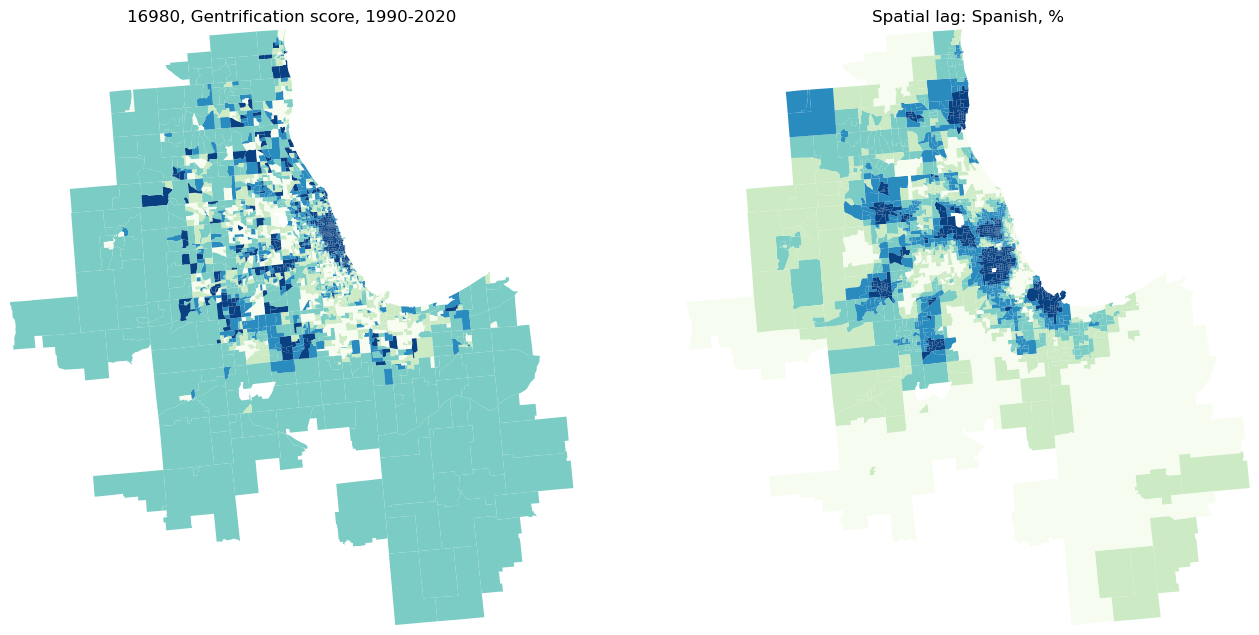

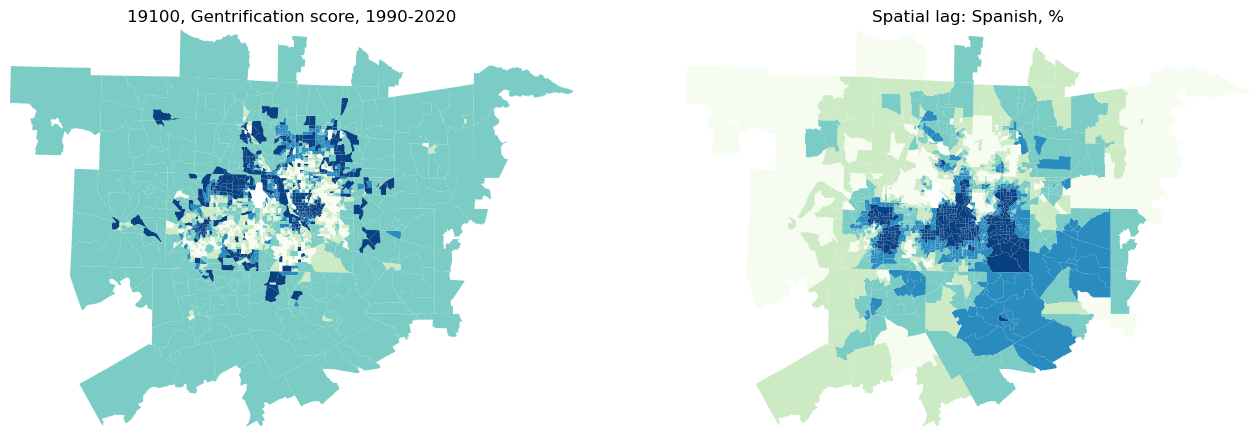

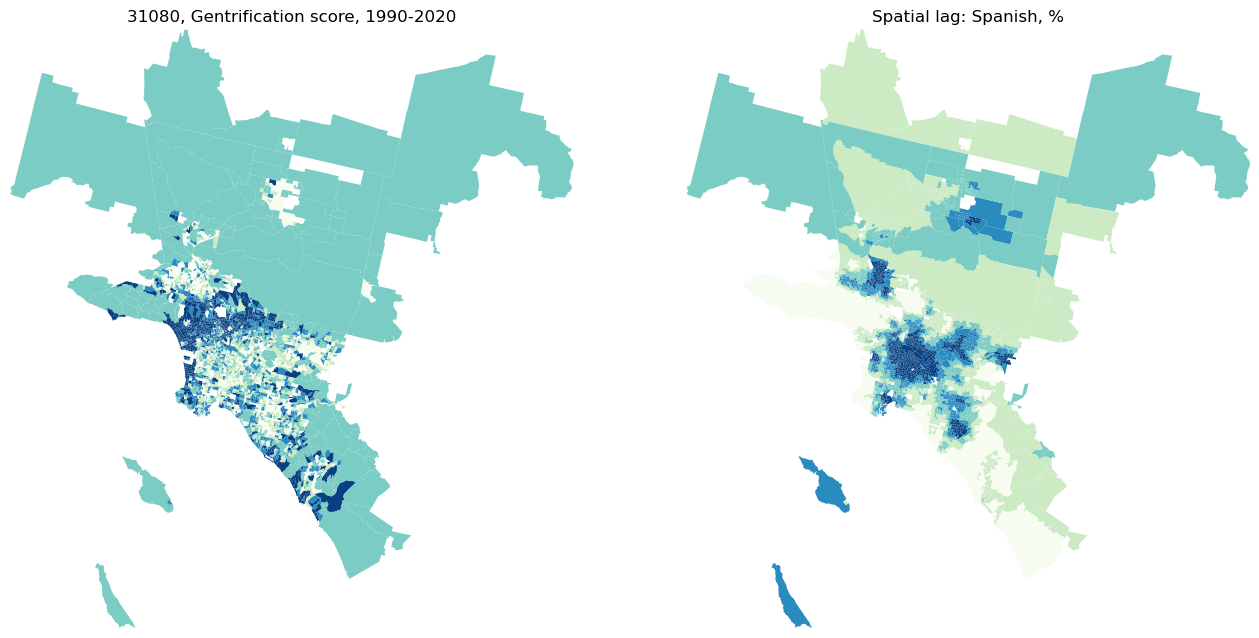

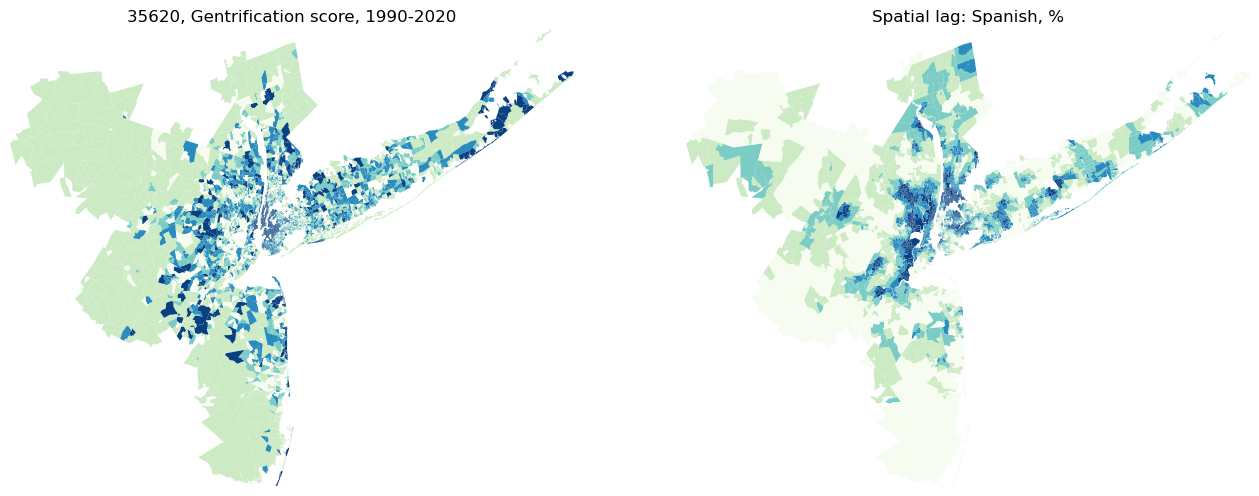

In [186]:
# chicago 
plot_cbsa("16980", gdf)

# dallas 
plot_cbsa("19100", gdf)

# la 
plot_cbsa("31080", gdf)

# ny 
plot_cbsa("35620", gdf)


#### **3. Spatial statistics**

<small>The data was analyzed by two metrics of autocorrelation, Bivariate Moran's I and Local Moran's I, and a third metric that seeks to compute a gentrification exposure index by language spoken population.
It was used the GIS libraries in the pysal.</small>

**3.1 Bivariate Moran's I**

<small>Gentrification Intensity, 1990-2020<br>
Percentage of languages spoken at home<br></small>

In [317]:
# function to computing bivariate moran's i

def compute_mi_bv(lang, gdf, x_gent, y_lang, w):
    x = gdf[x_gent].values
    y = gdf[y_lang].values
    
    # random seed to simulate pseudo p-values
    np.random.seed(12345)
    mi_bv = Moran_BV(x, y, w)
    
    return {
        "language": lang,
        "I": round(mi_bv.I, 2),
        "p_value": round(mi_bv.p_sim, 3),
        "z_score": round(mi_bv.z_sim, 2)
    }

In [188]:
results = []

for i in languages_per:
    res = compute_mi_bv(
        lang=i,
        gdf=gdf,
        x_gent="FAC_1990to2020",
        y_lang=i,
        w=weights,
    )
    results.append(res)

results

[{'language': 'english_only_per',
  'I': 0.1,
  'p_value': 0.001,
  'z_score': 12.66},
 {'language': 'spanish_per', 'I': -0.18, 'p_value': 0.001, 'z_score': -23.68},
 {'language': 'west_european_per',
  'I': 0.07,
  'p_value': 0.001,
  'z_score': 9.19},
 {'language': 'east_se_asian_per',
  'I': 0.04,
  'p_value': 0.001,
  'z_score': 5.62},
 {'language': 'slavic_languages_per',
  'I': 0.08,
  'p_value': 0.001,
  'z_score': 10.31},
 {'language': 'indo_european_per',
  'I': 0.08,
  'p_value': 0.001,
  'z_score': 11.32},
 {'language': 'arabic_per', 'I': 0.01, 'p_value': 0.251, 'z_score': 0.65}]

In [191]:
# df with the results

df_mi_bv = pd.DataFrame(results)

df_mi_bv["language"] = df_mi_bv["language"]
df_mi_bv["I"] = df_mi_bv["I"]
df_mi_bv["p_value"] = df_mi_bv["p_value"]
df_mi_bv["z_score"] = df_mi_bv["z_score"]

df_mi_bv

,language,I,p_value,z_score
0,english_only_per,0.10,0.001,12.66
1,spanish_per,-0.18,0.001,-23.68
2,west_european_per,0.07,0.001,9.19
3,east_se_asian_per,0.04,0.001,5.62
4,slavic_languages_per,0.08,0.001,10.31
5,indo_european_per,0.08,0.001,11.32
6,arabic_per,0.01,0.251,0.65


<small>**Considerations about Bivariate Moran's I results**</small><br>
<small>The most notorious result is the relation between gentrification intensity and the percentage of Spanish-speaking population. The global bivariate Moran’s I is negative at tract-level, and statistically significant, considering the very large z-score of –23.7, and p-score of 0.001. 
That means that as higher the gentrification index, more likely to be surrounded by tracts with low Spanish speakers population. Likewise, Spanish speakers tend to live in areas with low gentrification intensity. This pattern is observed across all the four metropolitan areas that includes Los Angeles, Chicago, Dallas, and New York –seleceted as the four most populated ones. The population from the other languages spoken varies from moderate to actually positive association, with the exception of the Arabic speakers population, wich was expressed no relation between gentrification intensity and their sharing in tracts from the four studied metropolitan areas.</small>



**3.2 Local Moran's I**

<small>Local indicators of Bivariate Spatial Association (LISA)<br>

x = gentrification intensity (FAC_1990to2020)<br>
y = % of a given language spoken at home</small>

In [252]:
# set up

# transforming in df
df_lisa = gdf.dropna(subset=["FAC_1990to2020", *languages_per]).copy()

# weights for lisa df
weights_lisa = lps.weights.Queen.from_dataframe(
    df_lisa,
    use_index=False,
    silence_warnings=True
)
weights_lisa.transform = "r"

# colors to be mapped later
colors_lisa = {
    "gent high, lang lag high": "#A8E746",
    "gent low, lang lag high": "#F948E1",
    "gent low, lang lag low":  "#35C9F6",
    "gent high, lang lag low": "#FFC05A",
    "not significant": "#E8E8E8",
}

# significance threshold
threshold = 0.05

In [308]:
# function to compute lisa for all languages
# zoom defined by main state of each metro area


def compute_lisa(cbsa, lang_per, gdf):

    # subset to this cbsa and drop nans
    cbsa = str(cbsa)
    metro = (
        gdf.loc[gdf["cbsa_code"] == cbsa, ["geoid", "cbsa_code", "FAC_1990to2020", lang_per, "geometry"]]
        .dropna(subset=["FAC_1990to2020", lang_per])
        .copy()
    )
    if metro.empty:
        print(f"No tracts found for CBSA {cbsa}")
        return None

    lang_label = lang_per.replace("_per", "").replace("_", " ")
    print(
        f"Clusters: Languages spoken at home and gentrification intensity\n"
        f"CBSA {cbsa}, {lang_label}: {len(metro)} tracts\n"
        "green: gent high, lang lag high\n"
        "pink: gent low, lang lag high\n"
        "blue: gent low, lang lag low\n"
        "orange: gent high, lang lag low"
    )

    # weights
    weights_metro = lps.weights.Queen.from_dataframe(
        metro,
        use_index=False,
        silence_warnings=True
    )
    weights_metro.transform = "r"


    # variables
    x = metro["FAC_1990to2020"].values.astype(float)
    y = metro[lang_per].values.astype(float)


    # local bivariate moran's i

    # warnings
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            category=RuntimeWarning,
            message="invalid value encountered in divide"
        )
        lisa_bv = Moran_Local_BV(x=x, y=y, w=weights_metro)

    # creating variables
    metro["Ii_bv"] = lisa_bv.Is
    metro["p_sim_bv"] = lisa_bv.p_sim
    metro["q_bv"] = lisa_bv.q
    metro["significant_bv"] = metro["p_sim_bv"] < threshold

    # creating cluster label column
    cluster = np.full(len(metro), "not significant", dtype=object)

    cluster[(metro["significant_bv"]) & (metro["q_bv"] == 1)] = "gent high, lang lag high" #green
    cluster[(metro["significant_bv"]) & (metro["q_bv"] == 2)] = "gent low, lang lag high" #pink
    cluster[(metro["significant_bv"]) & (metro["q_bv"] == 3)] = "gent low, lang lag low" #blue
    cluster[(metro["significant_bv"]) & (metro["q_bv"] == 4)] = "gent high, lang lag low" #orange

    metro["cluster_bv"] = cluster
    metro["color_lisa"] = metro["cluster_bv"].map(colors_lisa)

    # map clusters
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    metro.plot(
        color=metro["color_lisa"],
        linewidth=0,
        ax=ax,
    )

    ax.axis(metro.total_bounds[[0, 2, 1, 3]])
    ax.set_axis_off()
    
    plt.tight_layout()
    plt.show()

    return metro, weights_metro, lisa_bv


Clusters: Languages spoken at home and gentrification intensity
CBSA 16980, spanish: 2353 tracts
green: gent high, lang lag high
pink: gent low, lang lag high
blue: gent low, lang lag low
orange: gent high, lang lag low


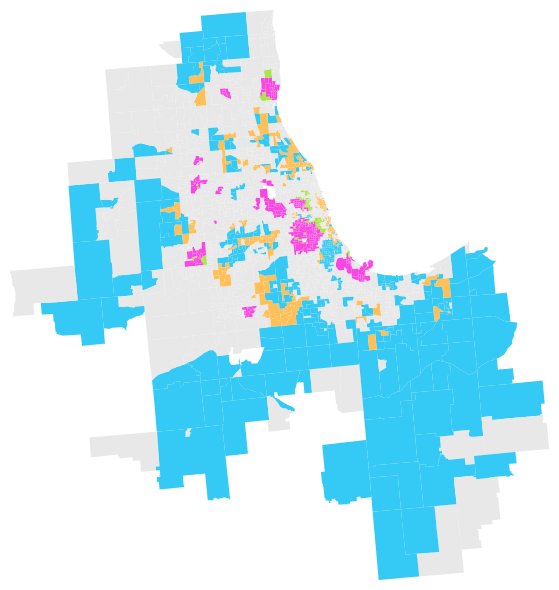

(             geoid cbsa_code  FAC_1990to2020  spanish_per  \
 3294   17031804509     16980       -0.781102        47.43   
 3295   17031230600     16980       -0.107595        64.23   
 3296   17031823702     16980       -0.865502         4.99   
 3297   17031520100     16980        0.346619        79.60   
 3298   17031800500     16980        1.107028         2.99   
 ...            ...       ...             ...          ...   
 12667  55059000604     16980        0.055006         8.47   
 12668  55059002606     16980        1.158501         9.80   
 12669  55059001800     16980       -0.747544        19.24   
 12670  55059003002     16980        0.000000         0.00   
 12686  55127001701     16980        0.000000        10.46   
 
                                                 geometry     Ii_bv  p_sim_bv  \
 3294   POLYGON ((644655.365 2138460.167, 644641.924 2... -0.705354     0.041   
 3295   POLYGON ((680660.981 2130473.146, 680656.149 2... -0.229091     0.002   
 3296   POL

In [309]:
#chicago
compute_lisa("16980", "spanish_per", df_lisa)

Clusters: Languages spoken at home and gentrification intensity
CBSA 19100, spanish: 1724 tracts
green: gent high, lang lag high
pink: gent low, lang lag high
blue: gent low, lang lag low
orange: gent high, lang lag low


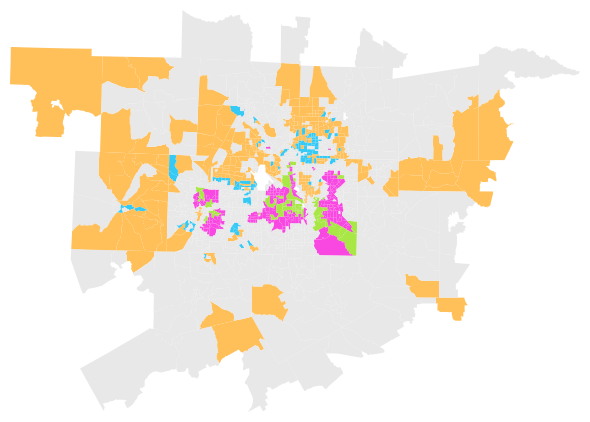

(             geoid cbsa_code  FAC_1990to2020  spanish_per  \
 10823  48035950100     19100        0.000000        15.30   
 10824  48085030405     19100       -0.195476        13.41   
 10825  48085031424     19100       -0.587658         8.97   
 10826  48085030545     19100        0.105169         6.99   
 10827  48085031335     19100        0.188327         3.49   
 ...            ...       ...             ...          ...   
 12617  48497150603     19100        0.000000        11.37   
 12618  48497150605     19100        0.000000        11.48   
 12619  48497150104     19100        0.000000        15.02   
 12620  48497150405     19100        0.000000         9.95   
 12621  48497150607     19100        0.000000        19.79   
 
                                                 geometry     Ii_bv  p_sim_bv  \
 10823  POLYGON ((-152704.27 1015932.505, -152514.627 ... -0.111477     0.192   
 10824  POLYGON ((-74469.461 1119133.18, -74410.817 11... -0.005550     0.034   
 10825  POL

In [310]:
#dallas
compute_lisa("19100", "spanish_per", df_lisa)

Clusters: Languages spoken at home and gentrification intensity
CBSA 31080, spanish: 3120 tracts
green: gent high, lang lag high
pink: gent low, lang lag high
blue: gent low, lang lag low
orange: gent high, lang lag low


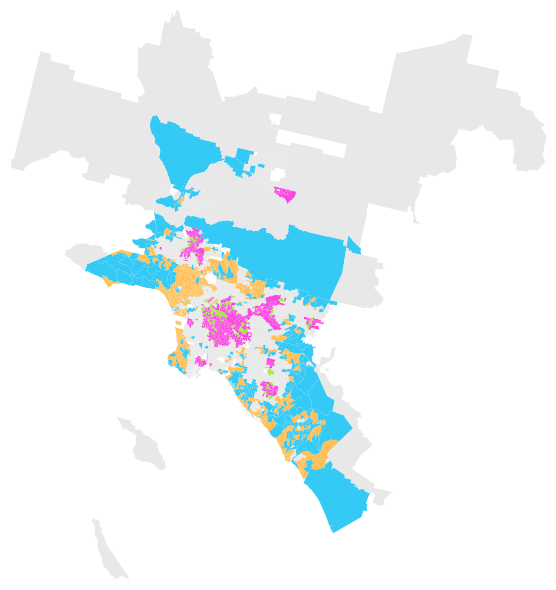

(            geoid cbsa_code  FAC_1990to2020  spanish_per  \
 0     06029005513     31080        0.000000        35.61   
 3     06029006011     31080        0.000000        11.04   
 7     06029005700     31080        0.000000         8.17   
 9     06029005514     31080        0.000000        34.46   
 11    06037227010     31080       -0.387495        84.80   
 ...           ...       ...             ...          ...   
 3236  06073018700     31080        0.000000        26.36   
 3237  06111008308     31080        0.000000         7.59   
 3241  06111009700     31080        0.000000        51.47   
 3246  06111007511     31080        0.000000         5.06   
 3250  06111007300     31080        0.000000        10.66   
 
                                                geometry     Ii_bv  p_sim_bv  \
 0     POLYGON ((-1994876.941 1547321.638, -1994862.9...  0.111935     0.141   
 3     POLYGON ((-2037015.621 1592555.214, -2036904.5...  0.053380     0.379   
 7     POLYGON ((-1954034.

In [311]:
#la
compute_lisa("31080", "spanish_per", df_lisa)

Clusters: Languages spoken at home and gentrification intensity
CBSA 35620, spanish: 4881 tracts
green: gent high, lang lag high
pink: gent low, lang lag high
blue: gent low, lang lag low
orange: gent high, lang lag low


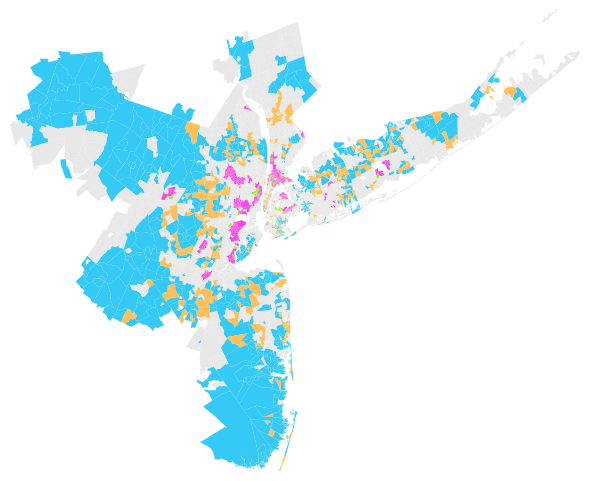

(             geoid cbsa_code  FAC_1990to2020  spanish_per  \
 5681   34003040002     35620       -0.329592         6.65   
 5682   34003021400     35620       -0.110948        35.94   
 5683   34003019306     35620       -0.088044         8.20   
 5684   34003007002     35620        0.340041         5.37   
 5685   34003023303     35620       -1.377922        22.77   
 ...            ...       ...             ...          ...   
 10816  42127961300     35620        0.000000         4.60   
 10818  42127960600     35620        0.000000         3.31   
 10819  42127961102     35620        0.000000         4.15   
 10820  42127961202     35620        0.000000         0.00   
 10821  42127961101     35620        0.000000         0.71   
 
                                                 geometry     Ii_bv  p_sim_bv  \
 5681   POLYGON ((1818228.926 2204948.122, 1818303.709...  0.437980     0.033   
 5682   POLYGON ((1814118.655 2196121.407, 1814188.25 ... -0.399848     0.026   
 5683   POL

In [312]:
#nyc
compute_lisa("35620", "spanish_per", df_lisa)

Clusters: Languages spoken at home and gentrification intensity
CBSA 16980, english only: 2353 tracts
green: gent high, lang lag high
pink: gent low, lang lag high
blue: gent low, lang lag low
orange: gent high, lang lag low


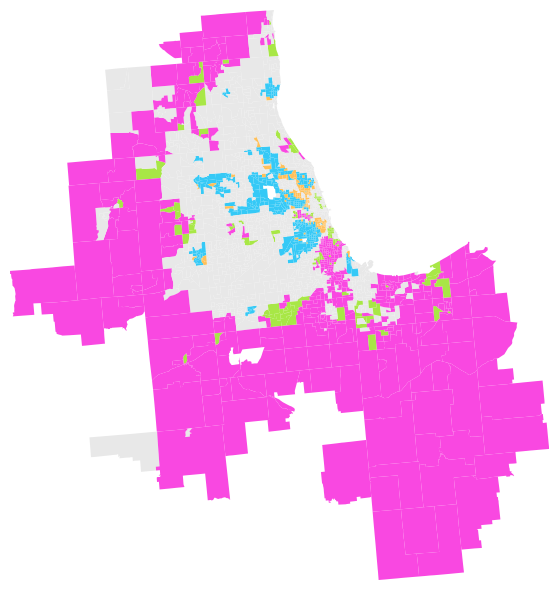

(             geoid cbsa_code  FAC_1990to2020  english_only_per  \
 3294   17031804509     16980       -0.781102             36.72   
 3295   17031230600     16980       -0.107595             34.52   
 3296   17031823702     16980       -0.865502             61.12   
 3297   17031520100     16980        0.346619             20.40   
 3298   17031800500     16980        1.107028             78.87   
 ...            ...       ...             ...               ...   
 12667  55059000604     16980        0.055006             82.64   
 12668  55059002606     16980        1.158501             85.01   
 12669  55059001800     16980       -0.747544             78.85   
 12670  55059003002     16980        0.000000             99.38   
 12686  55127001701     16980        0.000000             85.73   
 
                                                 geometry     Ii_bv  p_sim_bv  \
 3294   POLYGON ((644655.365 2138460.167, 644641.924 2...  0.765193     0.020   
 3295   POLYGON ((680660.981 213

In [313]:
#chicago
compute_lisa("16980", "english_only_per", df_lisa)

Clusters: Languages spoken at home and gentrification intensity
CBSA 19100, english only: 1724 tracts
green: gent high, lang lag high
pink: gent low, lang lag high
blue: gent low, lang lag low
orange: gent high, lang lag low


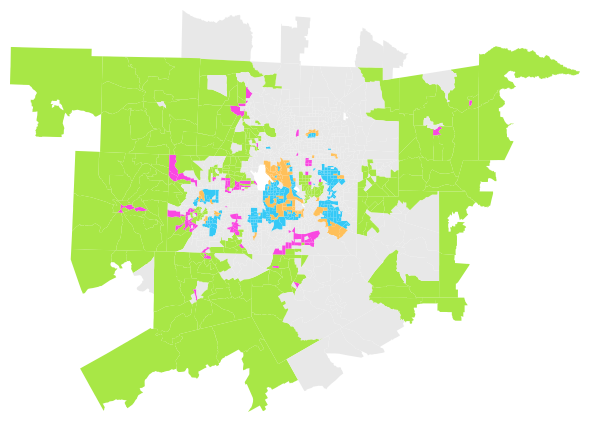

(             geoid cbsa_code  FAC_1990to2020  english_only_per  \
 10823  48035950100     19100        0.000000             84.58   
 10824  48085030405     19100       -0.195476             71.35   
 10825  48085031424     19100       -0.587658             77.35   
 10826  48085030545     19100        0.105169             82.42   
 10827  48085031335     19100        0.188327             75.72   
 ...            ...       ...             ...               ...   
 12617  48497150603     19100        0.000000             85.62   
 12618  48497150605     19100        0.000000             85.24   
 12619  48497150104     19100        0.000000             82.33   
 12620  48497150405     19100        0.000000             89.97   
 12621  48497150607     19100        0.000000             76.18   
 
                                                 geometry     Ii_bv  p_sim_bv  \
 10823  POLYGON ((-152704.27 1015932.505, -152514.627 ...  0.219109     0.011   
 10824  POLYGON ((-74469.461 111

In [314]:
#dallas
compute_lisa("19100", "english_only_per", df_lisa)

Clusters: Languages spoken at home and gentrification intensity
CBSA 31080, english only: 3120 tracts
green: gent high, lang lag high
pink: gent low, lang lag high
blue: gent low, lang lag low
orange: gent high, lang lag low


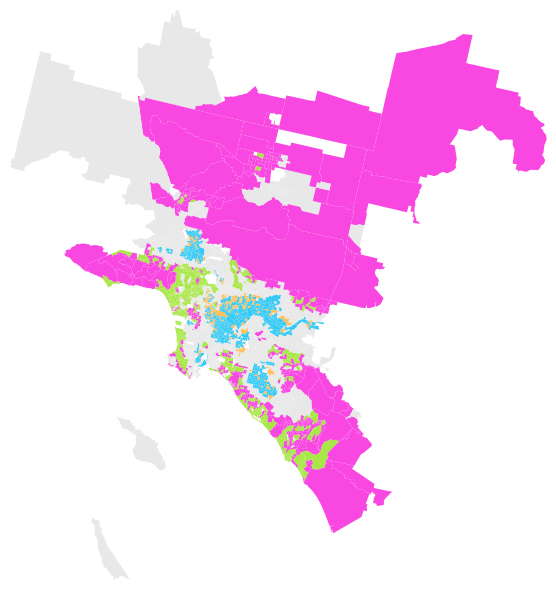

(            geoid cbsa_code  FAC_1990to2020  english_only_per  \
 0     06029005513     31080        0.000000             64.39   
 3     06029006011     31080        0.000000             81.10   
 7     06029005700     31080        0.000000             87.69   
 9     06029005514     31080        0.000000             56.12   
 11    06037227010     31080       -0.387495             15.20   
 ...           ...       ...             ...               ...   
 3236  06073018700     31080        0.000000             66.03   
 3237  06111008308     31080        0.000000             66.84   
 3241  06111009700     31080        0.000000             44.56   
 3246  06111007511     31080        0.000000             65.35   
 3250  06111007300     31080        0.000000             73.99   
 
                                                geometry     Ii_bv  p_sim_bv  \
 0     POLYGON ((-1994876.941 1547321.638, -1994862.9... -0.261939     0.007   
 3     POLYGON ((-2037015.621 1592555.214, -20

In [315]:
#la
compute_lisa("31080", "english_only_per", df_lisa)

Clusters: Languages spoken at home and gentrification intensity
CBSA 35620, english only: 4881 tracts
green: gent high, lang lag high
pink: gent low, lang lag high
blue: gent low, lang lag low
orange: gent high, lang lag low


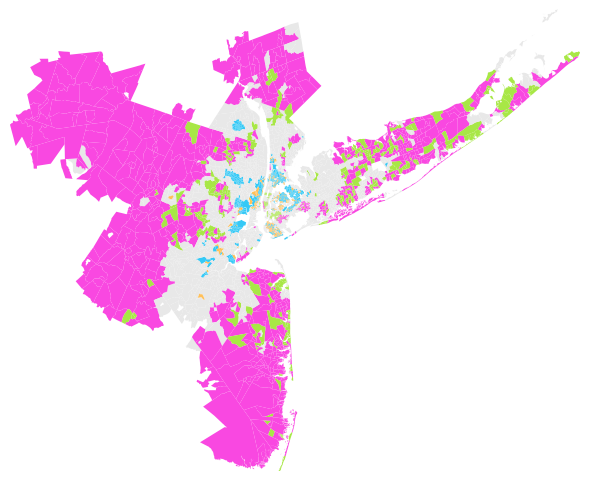

(             geoid cbsa_code  FAC_1990to2020  english_only_per  \
 5681   34003040002     35620       -0.329592             68.93   
 5682   34003021400     35620       -0.110948             36.56   
 5683   34003019306     35620       -0.088044             38.64   
 5684   34003007002     35620        0.340041             50.81   
 5685   34003023303     35620       -1.377922             56.55   
 ...            ...       ...             ...               ...   
 10816  42127961300     35620        0.000000             81.79   
 10818  42127960600     35620        0.000000             93.03   
 10819  42127961102     35620        0.000000             82.30   
 10820  42127961202     35620        0.000000             94.36   
 10821  42127961101     35620        0.000000             86.78   
 
                                                 geometry     Ii_bv  p_sim_bv  \
 5681   POLYGON ((1818228.926 2204948.122, 1818303.709... -0.211992     0.206   
 5682   POLYGON ((1814118.655 21

In [316]:
#nyc
compute_lisa("35620", "english_only_per", df_lisa)

**3.3 Shares of gentrification exposure index**

<small>Gentrification “Exposure” Indices by Language Group<br>
How much gentrification does the average person in each language group “experience”, given where they live?<br>
population-weighted average gentrification score by language group, plus (optionally) how much of each group lives in high-gentrification tracts.</small>

In [265]:
gdf_exp = gdf.dropna(subset=["FAC_1990to2020", "total"]).copy()

for lang in languages_per:
    gdf_exp[lang] = gdf_exp[lang].fillna(0)

In [266]:
# compute overall population-weighted average gentrification
# "average person"

overall_exposure = (
    (gdf_exp["FAC_1990to2020"] * gdf_exp["total"]).sum()
    / gdf_exp["total"].sum()
)

overall_exposure

0.2321233006927291

In [ ]:
# Compute exposure index for each language group

# exposure_index: gentrification index experienced by the average person in each language group
# excess_exposure > 0: language group resides, on average, in more gentrified tracts than the overall population
# excess_exposure < 0: language group resides, on average, in less gentrified tracts

rows = []

for lang in languages:
    pop_lang = gdf_exp[lang]
    total_lang = pop_lang.sum()
    
    if total_lang == 0:
        # avoid division by zero
        exposure = float("nan")
    else:
        exposure = (gdf_exp["FAC_1990to2020"] * pop_lang).sum() / total_lang
    
    rows.append({
        "language": lang,
        "exposure_index": exposure,
        "population_lang": total_lang
    })

df_exposure = pd.DataFrame(rows)

# adding comparison to overall population exposure
df_exposure["overall_exposure"] = overall_exposure
df_exposure["excess_exposure"] = df_exposure["exposure_index"] - overall_exposure

# rounding
df_exposure["exposure_index"] = df_exposure["exposure_index"].round(3)
df_exposure["overall_exposure"] = df_exposure["overall_exposure"].round(3)
df_exposure["excess_exposure"] = df_exposure["excess_exposure"].round(3)

df_exposure.sort_values("exposure_index", ascending=False)


,language,exposure_index,population_lang,overall_exposure,excess_exposure
2,west_european,0.474,362191.0,0.232,0.242
4,slavic_languages,0.378,433859.0,0.232,0.145
5,indo_european,0.370,914589.0,0.232,0.137
3,east_se_asian,0.323,1474611.0,0.232,0.091
0,english_only,0.283,11465296.0,0.232,0.051
6,arabic,0.199,139335.0,0.232,-0.033
1,spanish,-0.002,4185871.0,0.232,-0.234


In [ ]:
# shares of each language group by super-gentrified tracts
# each percentage is calculated in relation to each group's own population

gdf_exp["SuperGentrified"] = gdf["SuperGentrified"].astype(int)


super_rows = []

for lang in languages:
    pop_lang = gdf_exp[lang]
    total_lang = pop_lang.sum()

    if total_lang == 0:
        share_super = float("nan")
    else:
        share_super = (pop_lang[gdf_exp["SuperGentrified"] == 1].sum() / total_lang * 100)
    
    super_rows.append({
        "language": lang,
        "pct_in_super_gentrified": round(share_super, 2)
    })

df_super = pd.DataFrame(super_rows)
df_super

,language,pct_in_super_gentrified
0,english_only,6.15
1,spanish,3.31
2,west_european,6.48
3,east_se_asian,6.30
4,slavic_languages,7.57
5,indo_european,6.99
6,arabic,6.84


In [320]:
# shares of total population living in each super-gentrified tract
# each super-gentrified tracts by language group
# each percentage is calculated in relation to the total super-gentrified tract population

sg = gdf_exp[gdf_exp["SuperGentrified"] == 1]

rows = []

for lang in languages:
    pop_lang_sg = sg[lang].sum()
    rows.append({"language": lang, "super_gent_pop": pop_lang_sg})

df_super_share = pd.DataFrame(rows)
total_pop_sg = df_super_share["super_gent_pop"].sum()

df_super_share["super_gent_pop_per"] = (df_super_share["super_gent_pop"] / total_pop_sg * 100).round(2)
df_super_share


,language,super_gent_pop,super_gent_pop_per
0,english_only,704659.0,66.10
1,spanish,138630.0,13.00
2,west_european,23467.0,2.20
3,east_se_asian,92888.0,8.71
4,slavic_languages,32864.0,3.08
5,indo_european,63957.0,6.00
6,arabic,9524.0,0.89


In [ ]:
# shares of each language group by "normal" gentrified tracts
# each percentage is calculated in relation to each group's own population

gdf_exp["Gentrified"] = gdf["Gentrified"].astype(int)

normal_rows = []

for lang in languages:
    pop_lang = gdf_exp[lang]
    total_lang = pop_lang.sum()

    if total_lang == 0:
        share_normal = float("nan")
    else:
        share_normal = (pop_lang[gdf_exp["Gentrified"] == 1].sum() / total_lang * 100)
    
    normal_rows.append({
        "language": lang,
        "pct_in_super_gentrified": round(share_normal, 2)
    })

df_normal = pd.DataFrame(normal_rows)
df_normal

,language,pct_in_super_gentrified
0,english_only,13.94
1,spanish,9.75
2,west_european,15.86
3,east_se_asian,15.76
4,slavic_languages,19.50
5,indo_european,16.62
6,arabic,18.34


In [321]:
# shares of total population living in each "normal" gentrified tract
# each "normal" gentrified tracts by language group
# each percentage is calculated in relation to the total "normal" gentrified tract population

normal = gdf_exp[gdf_exp["Gentrified"] == 1]

normal_rows = []

for lang in languages:
    pop_lang_normal = normal[lang].sum()
    normal_rows.append({"language": lang, "normal_gent_pop": pop_lang_normal})

df_normal = pd.DataFrame(normal_rows)
total_pop_normal = df_normal["normal_gent_pop"].sum()

df_normal["normal_gent_pop_per"] = (df_normal["normal_gent_pop"] / total_pop_normal * 100).round(2)
df_normal


,language,normal_gent_pop,normal_gent_pop_per
0,english_only,1598645.0,62.48
1,spanish,408218.0,15.95
2,west_european,57432.0,2.24
3,east_se_asian,232361.0,9.08
4,slavic_languages,84590.0,3.31
5,indo_european,152035.0,5.94
6,arabic,25561.0,1.00


In [ ]:
# Spanish speakers groups: cluster away from gentrification
# Anglophone, European, and some Asian groups: cluster with gentrification
# Arabic groups: Not relevant results

**Considerations**<br>
<small>Local Moran’s I highlights where gentrification intensity and language concentration are most related across each metropolitan area. Overall, the analysis shows a non-uniform exposure to super-gentrified and gentrified tracts among the languages spoken groups. Again, the most notorious result is from the Spanish-speaking community, which has the lowest exposure of 3.5%. This metric reinforces the primary analysis of a strong negative spatial association between Spanish speakers population and gentrification scores.

In contrast, Slavic speakers, 8%, Indo-European speakers, 7.5%, and English-only speakers, 7.2%, show the highest exposure, indicating that the most gentrification processes happen in areas with higher concentrations of these groups. Overall, the findings suggest that there is a relationship between the process of gentrification and the languages spoken at home in US metropolitan areas. Specifically, it intensifies in English and European-origin languages higher concentrations, while largely bypassing areas with higher concentrations of Spanish speakers residents.</small>